In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from pypfopt import EfficientFrontier, risk_models, objective_functions, BlackLittermanModel, black_litterman

In [4]:
historical_returns = pd.read_csv('./sample/blm_asset_returns.csv', parse_dates=True, index_col = 'Year')
weights = pd.read_csv('./sample/blm_asset_weights.csv', parse_dates=True, index_col = 'asset_class')

In [5]:
# Select some asset classes
cols = [
    'Global Bonds (Unhedged)', 
    'Total US Bond Market', 
    'US Large Cap Growth', 
    'US Large Cap Value', 
    'US Small Cap Growth', 
    'US Small Cap Value', 
    'Emerging Markets', 
    'Intl Developed ex-US Market', 
    'Short Term Treasury'
]

returns = historical_returns[cols].dropna()
treasury_rate = returns['Short Term Treasury']

# exclude Treasury Rate from calculation
returns = returns.drop('Short Term Treasury', axis = 1).astype(float).dropna()
weights = weights.loc[cols[:-1]]

In [6]:
weights

,weight
asset_class,
Global Bonds (Unhedged),0.224
Total US Bond Market,0.077
US Large Cap Growth,0.163
US Large Cap Value,0.162
US Small Cap Growth,0.022
US Small Cap Value,0.022
Emerging Markets,0.030
Intl Developed ex-US Market,0.299


In [7]:
# Avg returns
returns.mean()

Global Bonds (Unhedged)        0.059615
Total US Bond Market           0.054231
US Large Cap Growth            0.131538
US Large Cap Value             0.102308
US Small Cap Growth            0.119615
US Small Cap Value             0.114615
Emerging Markets               0.100000
Intl Developed ex-US Market    0.063462
dtype: float64

In [8]:
# Excess Return
excess_returns = returns.subtract(treasury_rate, axis = 0)

# Covariance Matrix
cov = excess_returns.cov() 

# Global Return (Return of asset class * weights)
global_return = excess_returns.mean().multiply(weights['weight'].values).sum()

# Market Variance
weight_vector = weights.values.reshape(len(weights))
market_var = weight_vector.T @ cov @ weight_vector

print(f'Global Market Average Return is {global_return:.4f} with Market Variance equal to {market_var:.6}')

risk_aversion_coef = global_return / market_var
print(f'The Risk Aversion Coefficient is {risk_aversion_coef:.2f}')

Global Market Average Return is 0.0446 with Market Variance equal to 0.0202548
The Risk Aversion Coefficient is 2.20


/Users/pasin/Codes/Python/_investments/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


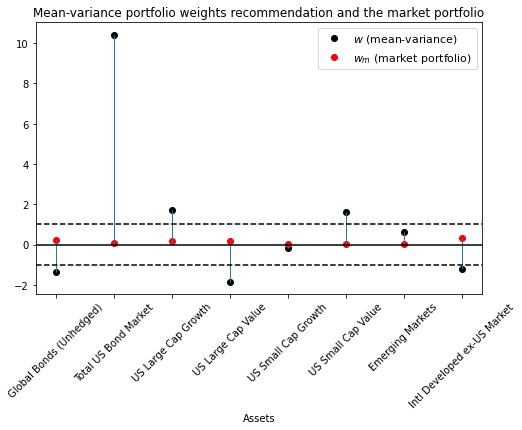

In [19]:
# weight from combining historical mean and variance to the Risk Aversion Coefficient
risk_aversion_weight = np.linalg.solve(risk_aversion_coef * cov, excess_returns.mean())

# visualize the difference between market cap weight and risk aversion weight 
assets = weights.index 
mcap_weight = weights['weight'].values

fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title('Mean-variance portfolio weights recommendation and the market portfolio')
ax.plot(assets, risk_aversion_weight, 'o', c='k', label='$w$ (mean-variance)')
ax.plot(assets, mcap_weight, 'o', c='r', label='$w_m$ (market portfolio)')
ax.vlines(assets, 0, risk_aversion_weight, lw=1)
ax.vlines(assets, 0, mcap_weight, lw=1)
ax.axhline(0, c='k')
ax.axhline(-1, c='k', ls='--')
ax.axhline(1, c='k', ls='--')
ax.set_xlabel('Assets')
ax.set_xticklabels(assets, rotation = 45)
plt.legend(numpoints=1, fontsize=11)
plt.show()

In [9]:
# Calculate implied returns 
def get_implied_returns(risk_aversion_coef, cov, weights):
    return risk_aversion_coef * (cov @ weights).squeeze()

implied_returns_eq = get_implied_returns(risk_aversion_coef=risk_aversion_coef, cov = cov, weights=weights)
implied_returns_eq

Global Bonds (Unhedged)        0.012871
Total US Bond Market           0.002439
US Large Cap Growth            0.060436
US Large Cap Value             0.051548
US Small Cap Growth            0.056798
US Small Cap Value             0.043902
Emerging Markets               0.076184
Intl Developed ex-US Market    0.063076
Name: weight, dtype: float64

In [10]:
# VIEWS
Q = np.array([0.0925, 0.005, 0.055])
P = np.array([
    [0, 0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0.85, -0.85, -0.15, -0.15, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 1]
])

# Calculate each view variance
n_views = len(Q)
view_var = []
for i in range(n_views):
    view_vector = P[i].reshape(len(P[i]))
    view_cov = view_vector.T @ cov @ view_vector
    view_var.append(view_cov)
    print(f'Variance of view {i} is {view_cov:.3f}')


Variance of view 0 is 0.097
Variance of view 1 is 0.015
Variance of view 2 is 0.045


In [11]:
view_var

[0.09655215384615386, 0.01534823115384617, 0.04505784615384616]

In [12]:
P

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.85, -0.85, -0.15, -0.15,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

In [13]:
# Find Omega
def get_error_cov_mat(cov, tau, P):
    return np.diag(
        np.diag(
            P @ (tau * cov) @ P.T
        )
    )

tau = 0.025
omega = get_error_cov_mat(cov = cov, tau = tau, P = P)

In [14]:
tmp = P @ (tau * cov) @ P.T
np.diag(np.diag(tmp))
# tmp

array([[0.0024138 , 0.        , 0.        ],
       [0.        , 0.00038371, 0.        ],
       [0.        , 0.        , 0.00112645]])

In [15]:
# Calculate View-based Return Vector
cov_scaled = cov * tau 
BLM_return_vector = implied_returns_eq + \
    cov_scaled @ P.T @ (
        np.linalg.inv(
            (P @ cov_scaled @ P.T) + omega 
        ) @ (Q - (
            P @ implied_returns_eq
        ))
    )
BLM_return_vector

Global Bonds (Unhedged)        0.013137
Total US Bond Market           0.002297
US Large Cap Growth            0.061663
US Large Cap Value             0.046864
US Small Cap Growth            0.054727
US Small Cap Value             0.037481
Emerging Markets               0.079109
Intl Developed ex-US Market    0.061875
dtype: float64

In [16]:
# Posterior Combined Return Vector (same as above, but this one is written following the real BLM formula)
posterior_return = np.linalg.inv(
    np.linalg.inv(tau * cov) + (P.T @ np.linalg.inv(omega) @ P)
) @ (
    (np.linalg.inv(tau * cov) @ implied_returns_eq) + (P.T @ np.linalg.inv(omega) @ Q)
)

In [17]:
# Calculate Black-Litterman references weights
inverse_cov = pd.DataFrame(np.linalg.inv(cov.values), index = cov.index, columns = cov.columns)

bl_weight_vector = inverse_cov.dot(posterior_return)
bl_weight_vector = bl_weight_vector / sum(bl_weight_vector)

In [18]:
bl_weight_vector

Global Bonds (Unhedged)        0.238999
Total US Bond Market           0.082156
US Large Cap Growth            0.341550
US Large Cap Value             0.005212
US Small Cap Growth           -0.006110
US Small Cap Value            -0.006110
Emerging Markets               0.099163
Intl Developed ex-US Market    0.245140
dtype: float64

In [19]:
# BL weight with pypfopt
ef = EfficientFrontier(bl_weight_vector, cov)


<h1 style="color:orange">Pypfopt's Black-Litterman</h1>

In [20]:
delta = black_litterman.market_implied_risk_aversion(excess_returns)
prior = black_litterman.market_implied_prior_returns(weights.to_dict()['weight'], delta, cov)
dummy_views = {ticker: 1 for ticker in weights.index}

# bl = BlackLittermanModel(cov_matrix = cov, absolute_views=dummy_views)
# bl._set_Q_P(Q, P)
bl = BlackLittermanModel(cov_matrix = cov, absolute_views = None, Q = Q, P = P, tau = tau)

/Users/pasin/Codes/Python/investments/env/lib/python3.7/site-packages/pypfopt/black_litterman.py:257: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


In [21]:
rets = bl.bl_returns()

In [22]:
# Black-Litterman's default Omega
default_omega = BlackLittermanModel.default_omega(cov, P, tau)

# Black-Litterman's default return function
tau_sigma_p = (tau * cov) @ P.T
A = (P @ tau_sigma_p) + omega
b = Q - P @ implied_returns_eq
y = implied_returns_eq + tau_sigma_p @ np.linalg.solve(A, b)

In [23]:
posterior_return

array([0.01313686, 0.00229663, 0.06166339, 0.04686381, 0.05472742,
       0.03748082, 0.07910885, 0.06187519])

In [24]:
y

Global Bonds (Unhedged)        0.013137
Total US Bond Market           0.002297
US Large Cap Growth            0.061663
US Large Cap Value             0.046864
US Small Cap Growth            0.054727
US Small Cap Value             0.037481
Emerging Markets               0.079109
Intl Developed ex-US Market    0.061875
dtype: float64